##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune Gemma models in Keras using LoRA

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/lora_tuning"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/335"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

Gemma is a family of lightweight, state-of-the art open models built from the same research and technology used to create the Gemini models.

Large Language Models (LLMs) like Gemma have been shown to be effective at a variety of NLP tasks. An LLM is first pre-trained on a large corpus of text in a self-supervised fashion. Pre-training helps LLMs learn general-purpose knowledge, such as statistical relationships between words. An LLM can then be fine-tuned with domain-specific data to perform downstream tasks (such as sentiment analysis).

LLMs are extremely large in size (parameters in the order of millions). Full fine-tuning (which updates all the parameters in the model) is not required for most applications because typical fine-tuning datasets are relatively much smaller than the pre-training datasets.

[Low Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685){:.external} is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. This makes training with LoRA much faster and more memory-efficient, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs.

This tutorial walks you through using KerasNLP to perform LoRA fine-tuning on a Gemma 2B model using the [Databricks Dolly 15k dataset](https://www.kaggle.com/datasets/databricks/databricks-dolly-15k){:.external}. This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

## Setup

### Get access to Gemma

To complete this tutorial, you will first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

Gemma models are hosted by Kaggle. To use Gemma, request access on Kaggle:

- Sign in or register at [kaggle.com](https://www.kaggle.com)
- Open the [Gemma model card](https://www.kaggle.com/models/google/gemma) and select _"Request Access"_
- Complete the consent form and accept the terms and conditions


### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
# !pip install -q -U keras-nlp
# !pip install -q -U keras>=3

### Select a backend

Keras is a high-level, multi-framework deep learning API designed for simplicity and ease of use. Using Keras 3, you can run workflows on one of three backends: TensorFlow, JAX, or PyTorch.

For this tutorial, configure the backend for JAX.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [2]:
import keras
import keras_nlp

## Load Dataset

Preprocess the data. This tutorial uses a subset of 1000 training examples to execute the notebook faster. Consider using more training data for higher quality fine-tuning.

In [3]:
import json
data = []
#with open('/kaggle/input/wizard-data/restaurant_data.jsonl') as file:
with open('/kaggle/input/geology-geophysics-qapair/geology_geophysics_qna.jsonl') as file:
    
    for line in file:
        features = json.loads(line)
        # Format the entire example as a single string.
#         template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        template = "Question:\n{Question}\n\nResponse:\n{Response}"
        data.append(template.format(**features))

# Only use N_rows training examples, to keep it fast.
# Nbre_rows is the nbre of rows to keep for the data
# Nbre_epoch is the total number of epoch to run
Nbre_epochs = 10
Nbre_rows=1000#250
data = data[:Nbre_rows]
#print(data)

## Load Model

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/){:.external}. In this tutorial, you'll create a model using `GemmaCausalLM`, an end-to-end Gemma model for causal language modeling. A causal language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method:

In [4]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

The `from_preset` method instantiates the model from a preset architecture and weights. In the code above, the string "gemma_2b_en" specifies the preset architecture — a Gemma model with 2 billion parameters.

NOTE: A Gemma model with 7
billion parameters is also available. To run the larger model in Colab, you need access to the premium GPUs available in paid plans. Alternatively, you can perform [distributed tuning on a Gemma 7B model](https://ai.google.dev/gemma/docs/distributed_tuning) on Kaggle or Google Cloud.

## Inference before fine tuning

In this section, you will query the model with various prompts to see how it responds.


In [5]:
#Question_prompt="What dishes are popular at the restaurant 'Akasaka Sushi Tempura Gion Iwai' located in Minato-ku, Tokyo?"
Question_prompt="How do sedimentary rocks form?"
prompt = template.format(
    Question=Question_prompt,
    Response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=2, seed=1)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Question:
How do sedimentary rocks form?

Response:
Sedimentary rocks are formed by the deposition and compaction of sediment. Sediment is the term used for the material that has settled out of a liquid or gas. Sedimentary rocks are formed when the sediment is deposited and compacted. The sediment may have been formed from the weathering of rocks, or from the remains of plants and animals. The sediment is deposited on the sea floor, or on the land. It is then compacted by the weight of the sediment above it. The compaction may be caused by waves, currents, or the weight of the overlying sediment. The sediment may be compacted to a solid rock, or it may be compacted to a layer of sediment. The compaction may also cause the sediment to be buried under other layers of sediment. The compaction may also cause the sediment to become cemented together.


## LoRA Fine-tuning

To get better responses from the model, fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [6]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,536,384 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,536,384 (9.34 GB)

 Trainable params: 1,363,968 (5.20 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.5 billion to 1.3 million).

In [7]:
# from tensorflow.keras import mixed_precision
# # Equivalent to the two lines above
# mixed_precision.set_global_policy('mixed_float16')
# Limit the input sequence length to 512 (to control memory usage).

gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
history=gemma_lm.fit(data, epochs=Nbre_epochs, batch_size=1)
# preset_dir = "/kaggle/working/"
# # Save the model
# gemma_lm.save_to_preset(f"{preset_dir}/gemma_model_"+str(N_rows))

#
model_version = '2b_en'
model_to_save ="gemma_model_"+str(model_version)+'_'+str(Nbre_rows)+'_'+str(Nbre_epochs)
model_variant ="gemma_model_"+str(Nbre_rows)+str(model_version)
# Save the finetuned model as a KerasNLP preset.
preset_dir = "./"+str(model_to_save)
gemma_lm.save_to_preset(preset_dir)



Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1400s 1s/step - loss: 0.0594 - sparse_categorical_accuracy: 0.8059
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1363s 1s/step - loss: 0.0139 - sparse_categorical_accuracy: 0.8937
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1352s 1s/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9068
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1352s 1s/step - loss: 0.0030 - sparse_categorical_accuracy: 0.9291
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1354s 1s/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9291
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1354s 1s/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9291
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1353s 1s/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9291
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1354s 1s/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9291
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1353s 1s/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9291
Epoch 10/10
1000/10

## Inference after fine-tuning
After fine-tuning, responses follow the instruction provided in the prompt.

In [8]:
# Trying to load working model
#Question_prompt="What dishes are popular at the restaurant 'Akasaka Sushi Tempura Gion Iwai' located in Minato-ku, Tokyo?"
Question_prompt="How do sedimentary rocks form?"
prompt = template.format(
    Question=Question_prompt,
    Response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=2, seed=1)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Question:
How do sedimentary rocks form?

Response:
Sedimentary rocks form from the accumulation of sediments.


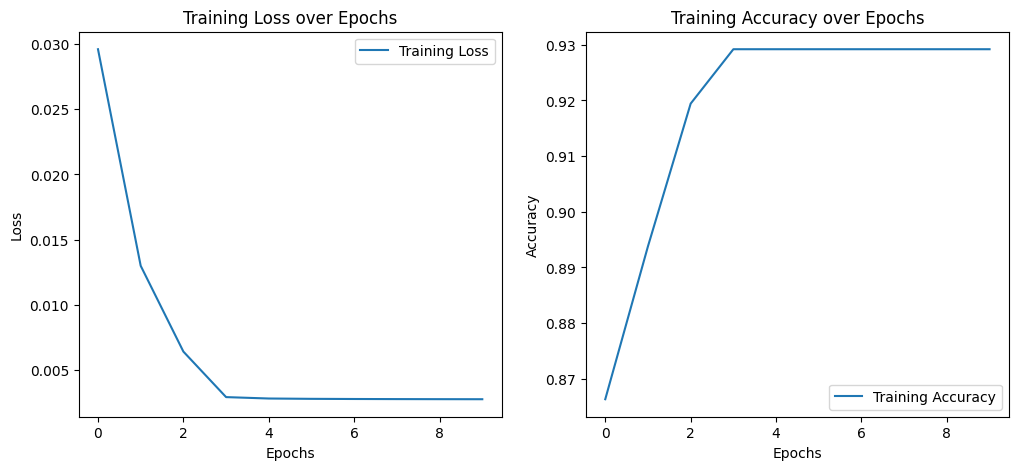

In [9]:
# Access the history attribute
# Extract the loss and accuracy
train_loss = history.history['loss']  # List of training loss for each epoch
train_accuracy = history.history['sparse_categorical_accuracy']  # List of training accuracy for each epoch

# Note: If validation data is provided during training, you can also access validation loss and accuracy
# val_loss = history.history['val_loss']
# val_accuracy = history.history['val_sparse_categorical_accuracy']

import matplotlib.pyplot as plt

# # Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()